In [3]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [19]:
def parse_log(content):
    iter_re = r'iteration\s*(\d+)/\s*\d+'
    time_re = r'elapsed time per iteration \(ms\): (\d+\.\d+)'
    iters, times = re.findall(iter_re, content), re.findall(time_re, content)
    return np.array(sorted([int(i) for i in iters])), np.array([float(i) for i in times if float(i) < 2000 and float(i) > 900])

def draw_itertime(itertimes):
    itertimes = np.array(itertimes)
    plt.plot(np.arange(len(itertimes)), itertimes)
    plt.xlabel("Iteration number")
    plt.ylabel("Iteration time / ms")

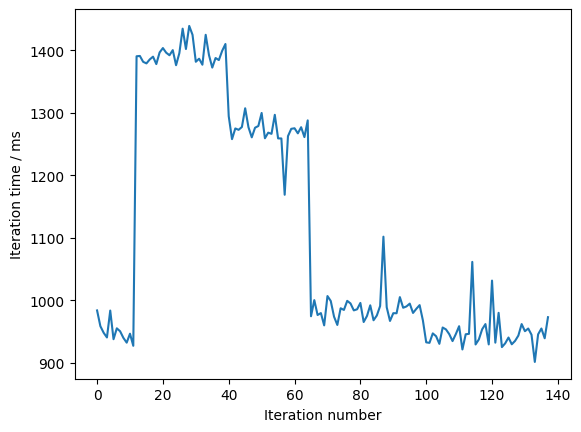

In [20]:
with open("./trainlogs/log.txt", 'r') as f:
    content = f.read()

iters, times = parse_log(content)
draw_itertime(times)